In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# Group proposal on developing predictive model in detecting and preventing forest fires in the Algerian regions.

In the Algerian regions(Northern Africa) of **Bejaia** and **Sidi Bel-abbes** during the period, between June 2012 and September 2012, forest fires ravaged an estimated 20,000 hectares of land. 
Our project aims to construct a prediction model for forest fires and we will use the Algerian Forest Fires Dataset, which contains data from two sub-regions.

**Brief explanation**
* Temperature: Degree Celsius
* RH: Relative Humidity (%)
* Ws: Wind speed (km/h)
* ISI (Initial Spread Index): estimation of the anticipated spread of a fire that is based on FFMC. 
* FFMC (fine fuel moisture code): the moisture content based on litter or other fine fuels. 
* DMC (Duff Moisture Code) and DC (Drought Code): is the average rating of moisture in the organic layers of the forest.
* BUI (Buildup Index): the total amount of fuel that can be used for a combustion reaction, this number is based on the DMC and the DC. 
* FWI (Fire Weather Index): the rating of the strength of the fire.



In [2]:
B_forestfire_data <- read_csv("Algerian_forest_fires_dataset_UPDATE.csv", skip = 1, 
                            col_types = "ncnnnnnnnnnnnf")%>%
                slice(1:124)%>%
                mutate(month = case_when(month == '06' ~ "June",
                                   month == '07' ~ "Jul",
                                   month == '08' ~ "Aug",
                                   month == '09' ~ "Sep"))%>%
                filter(Classes != 'Classes')
head(B_forestfire_data)

S_forestfire_data <- read_csv("Algerian_forest_fires_dataset_UPDATE.csv", skip = 126, 
                            col_types = "ncnnnnnnnnnnnf")%>%
                mutate(month = case_when(month == '06' ~ "June",
                                   month == '07' ~ "Jul",
                                   month == '08' ~ "Aug",
                                   month == '09' ~ "Sep"))%>%
                filter(Classes != 'Classes')
head(S_forestfire_data)

Warning message:
“16 parsing failures.
row         col   expected      actual                                       file
123 day         a number   -           'Algerian_forest_fires_dataset_UPDATE.csv'
123 NA          14 columns 1 columns   'Algerian_forest_fires_dataset_UPDATE.csv'
124 day         a number   day         'Algerian_forest_fires_dataset_UPDATE.csv'
124 year        a number   year        'Algerian_forest_fires_dataset_UPDATE.csv'
124 Temperature a number   Temperature 'Algerian_forest_fires_dataset_UPDATE.csv'
... ........... .......... ........... ..........................................
See problems(...) for more details.
”


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,June,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
2,June,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
3,June,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
4,June,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
5,June,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
6,June,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


Warning message:
“2 parsing failures.
row col   expected     actual                                       file
 44 FWI a number   fire       'Algerian_forest_fires_dataset_UPDATE.csv'
 44 NA  14 columns 13 columns 'Algerian_forest_fires_dataset_UPDATE.csv'
”


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,June,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2,not fire
2,June,2012,30,73,13,4.0,55.7,2.7,7.8,0.6,2.9,0.2,not fire
3,June,2012,29,80,14,2.0,48.7,2.2,7.6,0.3,2.6,0.1,not fire
4,June,2012,30,64,14,0.0,79.4,5.2,15.4,2.2,5.6,1.0,not fire
5,June,2012,32,60,14,0.2,77.1,6.0,17.6,1.8,6.5,0.9,not fire
6,June,2012,35,54,11,0.1,83.7,8.4,26.3,3.1,9.3,3.1,fire


**To tidy the dataset, we gave appropriate column types for the variables, the ‘Classes’ column was filtered out due to some rows of NA data.**

In [3]:
#1
nrow(S_forestfire_data) + nrow(B_forestfire_data)

#2
count_S <- S_forestfire_data %>%
                group_by(Classes) %>%
                summarize(n = n())
count_S
count_B <- B_forestfire_data%>%
                group_by(Classes) %>%
                summarize(n = n())
count_B



[1] 243

`summarise()` ungrouping output (override with `.groups` argument)



Classes,n
<fct>,<int>
not fire,43
fire,78


`summarise()` ungrouping output (override with `.groups` argument)



Classes,n
<fct>,<int>
not fire,63
fire,59


`summarise()` regrouping output by 'month' (override with `.groups` argument)

`summarise()` regrouping output by 'month' (override with `.groups` argument)



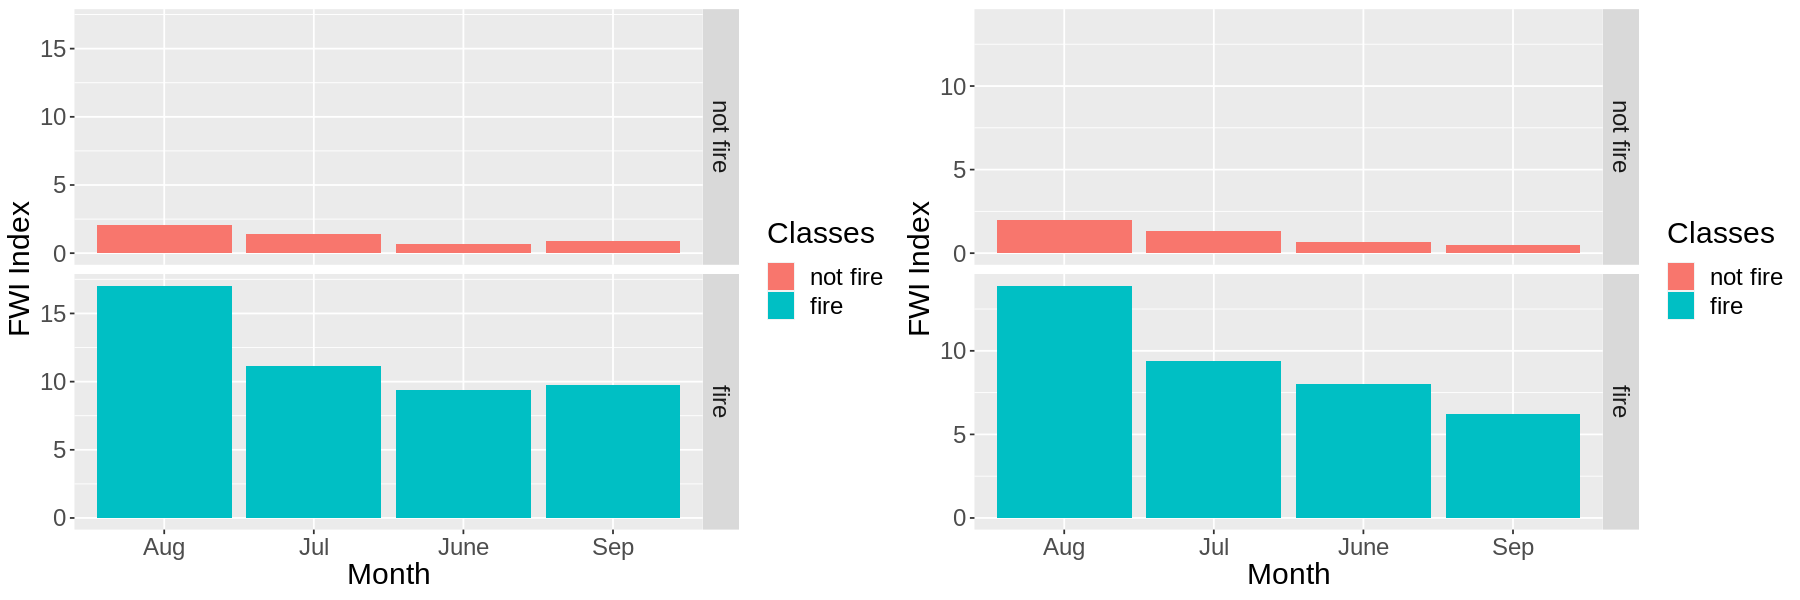

In [4]:
#3
S_FWI <- S_forestfire_data %>%
            select(FWI, Classes, month) %>%
            group_by(month, Classes)%>%
            summarize(FWI = mean(FWI)) %>%
            arrange(FWI)

S_FWI_plot <- S_FWI %>%
                    ggplot(aes(x = month, y = FWI, fill = Classes))+
                    geom_bar(stat = "identity")+
                    facet_grid(Classes~.)+
                    labs(x = "Month", y = "FWI Index", fill = "Classes")+
                    theme(text = element_text(size = 18))


B_FWI <- B_forestfire_data %>%
            select(FWI, Classes, month) %>%
            group_by(month, Classes)%>%
            summarize(FWI = mean(FWI)) %>%
            arrange(FWI)

B_FWI_plot <- B_FWI %>%
                    ggplot(aes(x = month, y = FWI, fill = Classes))+
                    geom_bar(stat = "identity")+
                    facet_grid(Classes~.)+
                    labs(x = "Month", y = "FWI Index", fill = "Classes")+
                    theme(text = element_text(size = 18))
options(repr.plot.width = 15, repr.plot.height = 5)
plot_grid(S_FWI_plot,B_FWI_plot, ncol = 2)
            

**Exploratory Steps**

Firstly,this is a small dataset and we decided to slice the data with 76% for the training set and 24% for the testing set. This will ensure that the training set is large enough while still having sufficient data for the testing set to test the accuracy

We explored the data to see their sizes and the count under each class. We made tables and plots of FWI values evaluating whether a fire class always has a greater FWI value than a non-fire class in two subregions.

We'll use different variables to create scatter plots to visualize the relationships between the vectors.


In [5]:
set.seed(10)

B_forest_split <- initial_split(B_forestfire_data, prop = 0.76, strata = Classes)
S_forest_split <- initial_split(S_forestfire_data, prop = 0.76, strata = Classes)

B_training <- training(B_forest_split)
B_testing <- testing(B_forest_split)

S_training <- training(S_forest_split)
S_testing <- testing(S_forest_split)

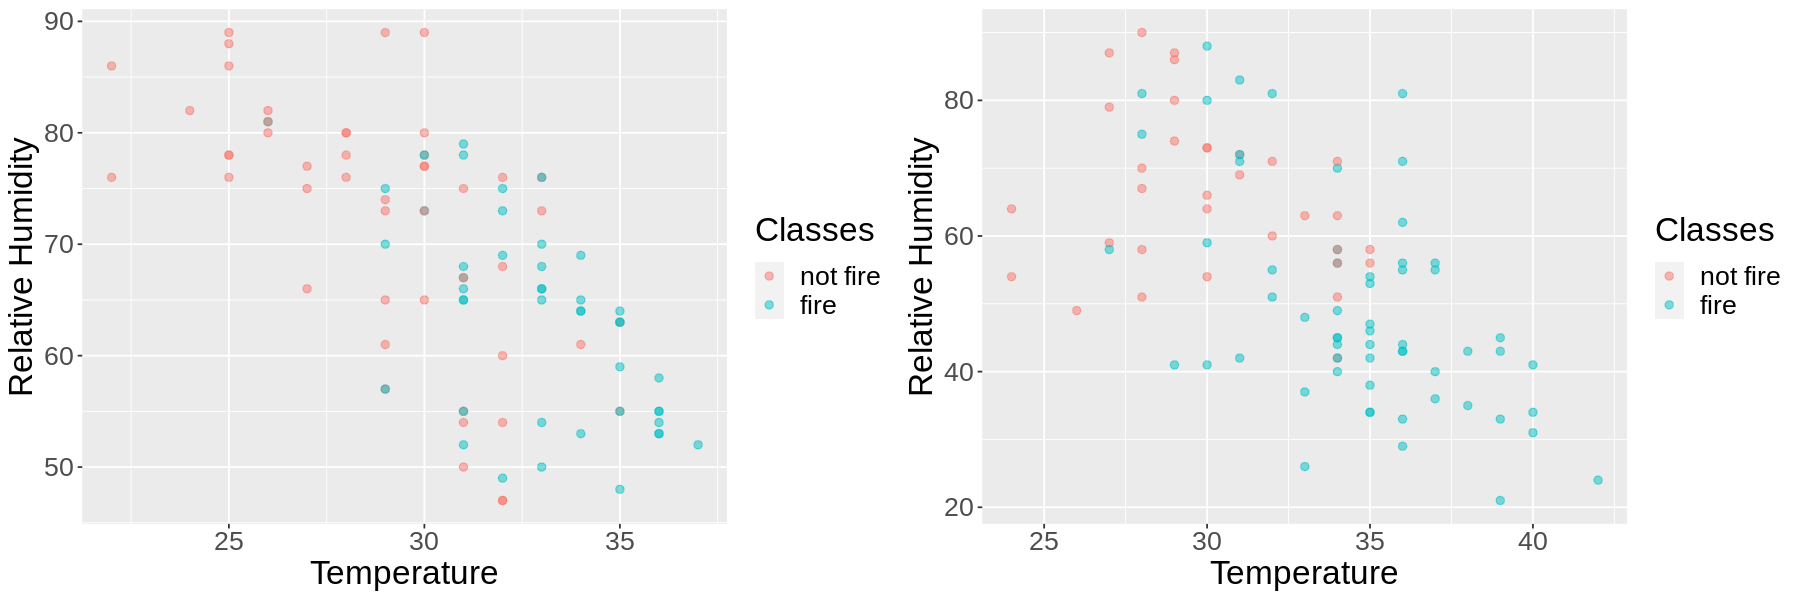

In [6]:
options(repr.plot.width = 15, repr.plot.height = 5)

temp_ws <- B_training %>%
            ggplot(aes(x = Temperature, y = RH, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Temperature",y = "Relative Humidity", color = "Classes")+
            theme(text = element_text(size = 20))

s_temp_ws <- S_training %>%
            ggplot(aes(x = Temperature, y = RH, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Temperature",y = "Relative Humidity", color = "Classes")+
            theme(text = element_text(size = 20))

plot_grid(temp_ws,s_temp_ws, ncol = 2)

**Both plots showed a negative moderately strong linear relationship. Fires become more likely to occur as temperatures increase and relative humidity decreases.Fires predominantly occur when temperatures are above thirty degrees Celsius and relative humidity is less than 70.**

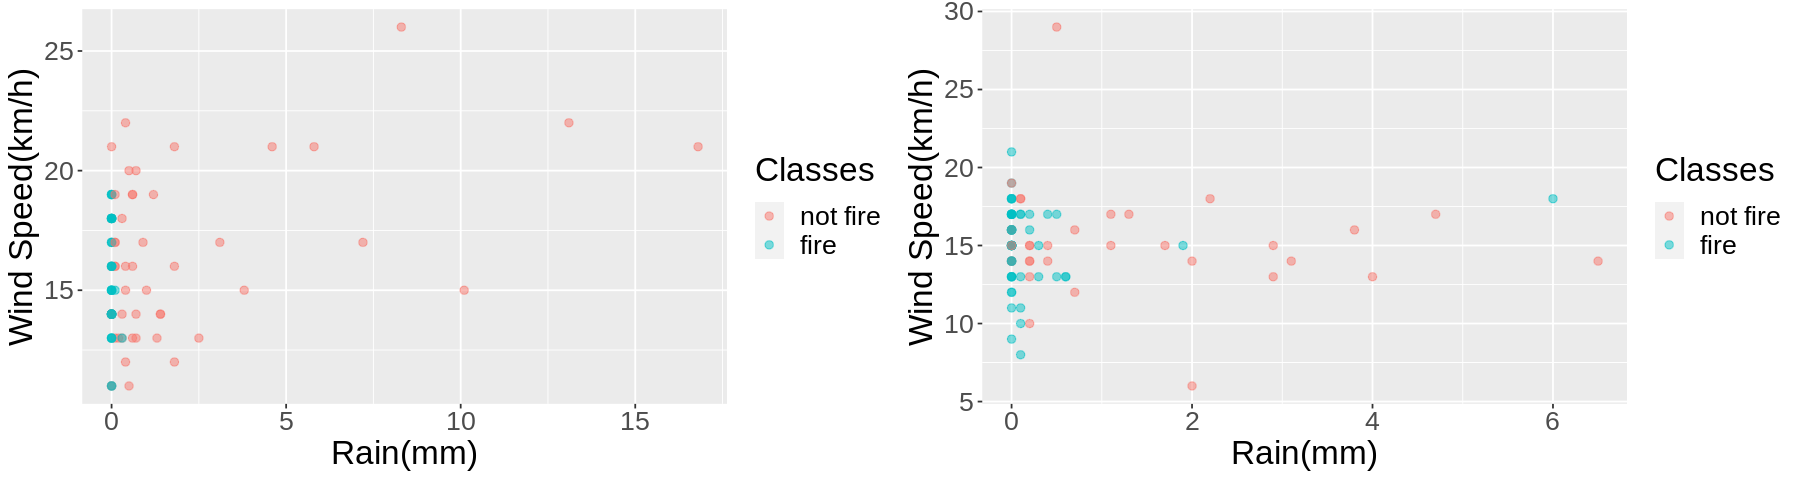

In [7]:
options(repr.plot.width = 15, repr.plot.height = 4)

rain_ws_1 <- B_training %>%
            ggplot(aes(x = Rain, y = Ws, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Rain(mm)",y = "Wind Speed(km/h)", color = "Classes")+
            theme(text = element_text(size = 20))

rain_ws_2 <- S_training %>%
            ggplot(aes(x = Rain, y = Ws, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Rain(mm)",y = "Wind Speed(km/h)", color = "Classes")+
            theme(text = element_text(size = 20))
plot_grid(rain_ws_1,rain_ws_2, ncol = 2)

**From these plots, we realized the dataset needs to be scaled and centred.**

In [8]:

SS_training <- S_training %>%
                        mutate(Temperature = scale(Temperature, center = TRUE),
                              RH = scale(RH, center = TRUE),
                              Ws = scale(Ws, center = TRUE),
                              Rain = scale(Rain, center = TRUE))



In [ ]:
options(repr.plot.width = 15, repr.plot.height = 4)

b_rain_ws <- SB_training %>%
            ggplot(aes(x = Rain, y = Ws, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Rain(mm)",y = "Wind Speed(km/h)", color = "Classes")+
            theme(text = element_text(size = 20))

s_rain_ws <- SS_training %>%
            ggplot(aes(x = Rain, y = Ws, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Rain(mm)",y = "Wind Speed(km/h)", color = "Classes")+
            theme(text = element_text(size = 20))
plot_grid(b_rain_ws,s_rain_ws, ncol = 2)

**Method**

* Further tuning the classifiers using cross-validation with C = 5, which would prevent the data from under fitting or overfitting, and each observation will only be used once in a validation set.
* Picking a K value by visualizing the Accuracy Estimation vs. Number of Neighbours for the classification models.
* Developing two models: one with only FWI as predictor and the other with four vectors from column Temperature to column Rain. Testing and comparing their accuracies on testing datasets.


**Expected outcomes and significance**

We expect to find that the model could predict future forest fires with an accuracy above 82%. This result can be applied to proactive methods to prevent and detect fire signals. We can think of further inquiries such as, does the model fit for other regions in this country, and what about other countries?
